<a href="https://colab.research.google.com/github/andreagrioni/Tutorials/blob/master/Kaggle_fetal_health_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetal Health Classification

The url of the Kaggle competition is available [here](https://www.kaggle.com/andrewmvd/fetal-health-classification)

## Download Dataset

This block uses the kaggle api to download the dataset. You need a Kaggle account and credential to use it. The instruction on how to use the Kaggle API can be found on [GitHub](https://github.com/Kaggle/kaggle-api)


In [ ]:
# %env KAGGLE_CONFIG_DIR=/YOUR/PATH/HERE/kaggle.json
# ! chmod 600 $KAGGLE_CONFIG_DIR
# ! kaggle datasets download -d andrewmvd/fetal-health-classification

## Goals

### Task Details
Create a model to classify the outcome of Cardiotocogram (CTG) exam (which represents the well being of the fetus).

### Notes
Note that this is a multiclass problem that can also be treated as regression (since the labels are progressive).
Also note that there is considerable class imbalance and therefore accuracy is not recommended as primary metric and stratification is recommended when splitting the data.

### Evaluation
With a testing set of size of 30% of all available data, calculate some of the recommended metrics bellow:

- Area under the ROC Curve
- F1 Score
- Area under the Precision-Recall Curve

**Have fun!**

## Data Exploratory Analysis

This block provides a short oveview on the dataset. This step can help to identify important features of the dataset.

1. load dataset as pandas dataframe
2. generate different plots

Kaggle provides a great introduction to Pandas dataframes [here](https://www.kaggle.com/learn/pandas)

In [1]:
# import pandas library (it is already installed on Google Colab)
import pandas as pd

dataset_filepath = "./fetal-health-classification.zip"
# the pandas argument compression tells pandas to extract the file
df = pd.read_csv(dataset_filepath, compression='zip')
# show first 10 lines of the dataset
df.head(10)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.000,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.000,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.000,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.000,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0
5,134.0,0.001,0.0,0.010,0.009,0.0,0.002,26.0,5.9,0.0,0.0,150.0,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0,3.0
6,134.0,0.001,0.0,0.013,0.008,0.0,0.003,29.0,6.3,0.0,0.0,150.0,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0,3.0
7,122.0,0.000,0.0,0.000,0.000,0.0,0.000,83.0,0.5,6.0,15.6,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
8,122.0,0.000,0.0,0.002,0.000,0.0,0.000,84.0,0.5,5.0,13.6,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0,3.0
9,122.0,0.000,0.0,0.003,0.000,0.0,0.000,86.0,0.3,6.0,10.6,68.0,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0,3.0


### Pandas Profiling

A fast way of Exploratory Data Analysis is to run the Pandas Profiling on our dataset.

The Pandas Profiling GitHub repo is [here](https://github.com/pandas-profiling/pandas-profiling)

In [2]:
# it may be possible that you need to re-install the latest version of the 
# profiler. This will allows compatibility with pandas >= 1.0.0v.
# The following command will download and install the latest version of pandas_prifiling, 
# and it may requires you to restart the instace.
# you can restart the instance (Virtual Machine) from the main tab:
# Runtime > Restart runtime
# Restart runtime will erase the memory but not the storage, therefore you will
# not need to re-run the below command as well as re-download the dataset from 
# Kaggle.
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
ERROR: Operation cancelled by user


### Run the profiler

The block below will import the profiler and
run a standard profiling job.

Results can be visually explored.


In [5]:
# import the pandas_profiling library
import pandas_profiling

# run profiler | set minimal=True to speed up the profiling
profile = pandas_profiling.ProfileReport(df=df, minimal=False)
profile.to_notebook_iframe()
# save report in the working directory
profile.to_file("fetal_health_dataset.html")

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Observations

From the profiler above you should look at:
- NA values
- duplicate rows
- distribution of values
- categorical vs numerical features

The warning tab in the profiler Overview. 
The Warnings Overview shows that we have 13 duplicates rows and a consistent number of rows with zeros as value.

### Dataset CleanUp

We will remove duplicates rows only for the moment.

The Pandas dataframe method `drop_duplicate` will remove
duplicate rows and return a new dataframe.

The Pandas dataframe attribute `shape` can be called to get the dimension of the dataframe, as row x cols.

The f-string formatting can be used to print a log file while executing code in it. You can declare a f-string by adding 'f' at the start of the string.
You can evaluate expression within a string by surraunding it with { YOUR EXPRESSION }

example of f-string

```python
name = "USER"
f_string = f"this is a new {name}"
print(f_string)
```

output

```python
this is a new USER
```




In [12]:
# call drop_duplicate method on df
df_clean = df.drop_duplicates()
# print log
print(f"original dataframe dimension is:\t{df.shape}\nnew dataframe dimension is:\t{df_clean.shape}")

original dataframe dimension is:	(2126, 22)
new dataframe dimension is:	(2113, 22)


### Train Test Split

A good practice is to split your dataset into train and test set. The train set will be used to train the model (thus to optimize the paramenters of your model), while the test set will be used to run an indipendent evaluation of the model performances. If you have a large dataset, you may split it into train, validation and test sets. The additional validation test can be used to fine tuned the model while training.

For this example we will split the dataset into train and test sets using the utility `train_test_split` from scikit-learn library.

You can read more on sk_learn [here](https://scikit-learn.org/stable/) |
You can read more on `train_test_split` [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split)

In [14]:
from sklearn.model_selection import train_test_split

# train_test_split takes as input features and labels of the dataset.
# First, we need to separate labels and features into two distintict datasets.

features = df_clean.drop(['fetal_health'], axis=1) # axis == 1 tells to pandas to drop along column
labels = df_clean['fetal_health']

X_train, X_test, y_train, y_test = train_test_split(
    features, # provide dataset features
    labels, # provide dataset labels
    test_size=0.3, # define the size for test set
    random_state=1 # define a seed for reproducibility
    )

### Model

#### Train
This block implements the light Gradient Boosting Machine from Microsoft, aka lightGBM. 

LightGBM is a very fast and powerful machine learning algorithm. It works with relative small dataset, which is an advantage in our field of applications. Another important aspect of lightGBM is that it works with categorical features without the need of one hot encoding.


- documentation [here](https://lightgbm.readthedocs.io/en/latest/)
- GitHub [here](https://github.com/microsoft/LightGBM)



In [16]:
from lightgbm import LGBMClassifier, Dataset

model = LGBMClassifier()
model.fit(X_train, y_train)


#### Test

We need to test the performances of our model.
There are several metrics that can be applied to define how good the model does on unseen data (test set).

The herein dataset is unbalanced, meaning that the different categories are not equally represented. This unbalanced situation may results in the model doing very good in recognizing a specific category, while negletting the others.

For this reason, we need to select a metrics that is design for this type of situation. A good one is the F1-score. F1-score is the harmonic mean of the precision and recall.

It is evaluated described at the wiki page [here](https://en.wikipedia.org/wiki/F-score).

The sk-learn API provides a method to calculate the F1-score of your prediction [url](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score).

A good post on multi-class metrics is available [here](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1)

In [34]:
from sklearn.metrics import f1_score

# first we need to get our prediction
prediction = model.predict(X_test)
# calculate f1-score
f1_score(
    y_test, # ground truth or real values
    prediction,
    average='macro' # macro is the arithmetic means of the per-categories F1-scores 
)

0.8860391359142983

### Confusion Matrix

Running this block of code will generate a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix).

A confusion matrix is a powerful visualazion tool to help understand which are the categories that are fooling the model.

We can see that our model is mainly 'confused' in the discrimination between categories 1 and 2.

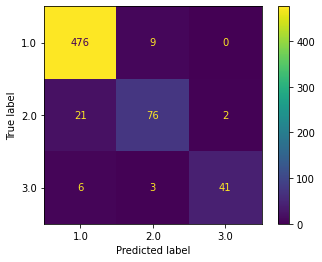

In [47]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(
    estimator=model,
    X=X_test,
    y_true=y_test,
    normalize=None,
    values_format='d'
    )

### What to do now?

Several things can be done now to improve the model.

- undertand which are the most important features for the model to make a decision. A good paper on the topic [here](https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D)

- change the paramenters of the `LGBMClassifier()` object. A list is provided [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#)

- setting up a hyperparaments search to automatically discover the best combination of paramenters. A good API is [optuna](https://optuna.org/)